In [1]:
# !pip install easydict

In [2]:
import easydict
args = easydict.EasyDict({
        "learning_rate":1e-3,
        "learning_rate_D":1e-4,
        "learning_rate_D_local":1e-4,
        "gan":"lsgan",
        "model":"scribbler",
        "num_epoch":100,
        "feature_weight":0,
        "global_pixel_weight_l":0,
        "local_pixel_weight_l":1,
        "pixel_weight_ab":0,
        "pixel_weight_rgb":0,
        "discriminator_weight":0,
        "discriminator_local_weight":0,
        "style_weight":0,
        "visualize_every":10,
        "batchsize": 1,
        "epoch": 20,
        "cpu": [0],
        "cpu": 1,
        "display_port":8097,
        "data_path":"/Users/spuliz/Desktop/NN/textureGan/training_handbags_pretrain",
        "save_dir":"/test",
        "load_dir":"/test",
        "save_every":1000,
        "load_epoch":-1,
        "load_epoch":-1,
        "load_D":-1,
        "image_size":152,
        "resize_to":300,
        "resize_max":2560,
        "resize_min":2560,
        "patch_size_min":20000,
        "patch_size_max":400000,
        "batch_size":32,
        "num_input_texture_patch":2,
        "num_local_texture_patch":1,
        "color_space":"lab",
        "threshold_D_max":0.8,
        "content_layers":"relu4_2",
        "style_layers": "relu3_2, relu4_2",
        "use_segmentation_patch": True,
        "input_texture_patch": "dtd_texture",
        "loss_texture": "dtd_texture",
        "local_texture_size": 50,
        "texture_discrminator_loss": True,
        "tv_weight":1,
        "mode":"texture",
        "visualize_mode": "train",
        "crop":"random",
        "contrast": True,
        "occlude": False,
        "checkpoints_path": "data/",
        "noise_gen": False,
        "absolute_load": "",
        "out": "result",
        "resume": False,
        "unit": 1000
})

In [3]:
pwd

'/Users/spuliz/Desktop/NN/textureGan'

In [4]:
import os.path
from os import path

def main():

  #  print ("Is it Directory?" + str(path.isdir('guru99.txt')))
   print ("Is it Directory?" + str(path.isdir('/Users/spuliz/Desktop/NN/textureGan/training_handbags_pretrain')))

if __name__== "__main__":
   main()

Is it Directory?True


In [5]:
# from main import get_transforms
# from dataloader import imfol
# from dataloader.imfol import ImageFolder, make_dataset
import torch
import torch.utils.data as data
from torch.utils.data.sampler import SequentialSampler
from torch.utils.data import DataLoader
import math
from torch.autograd import Variable
# from utils.visualize import vis_patch, vis_image

In [6]:
def get_transforms(args):
    transforms_list = [
        RandomSizedCrop(args.image_size, args.resize_min, args.resize_max),
        RandomHorizontalFlip(),
        toTensor()
    ]
    if args.color_space == 'lab':
        transforms_list.insert(2, toLAB())
    elif args.color_space == 'rgb':
        transforms_list.insert(2, toRGB('RGB'))

    transforms = Compose(transforms_list)
    return transforms

In [7]:
def default_loader(path):
    return pil_loader(path)

In [8]:
def make_dataset(directory, opt, erode_seg=True):
    # opt: 'train' or 'val'
    img = glob.glob(osp.join(directory, opt + '_img/*/*.jpg'))
    img = sorted(img)
    skg = glob.glob(osp.join(directory, opt + '_skg/*/*.jpg'))
    skg = sorted(skg)
    seg = glob.glob(osp.join(directory, opt + '_seg/*/*.jpg'))
    seg = sorted(seg)
    txt = glob.glob(osp.join(directory, opt + '_txt/*/*.jpg'))
    #txt = glob.glob(osp.join(directory, opt + '_dtd_txt/*/*.jpg'))
    extended_txt = []
    #import pdb; pdb.set_trace()
    for i in range(len(skg)):
        extended_txt.append(txt[i%len(txt)])
    random.shuffle(extended_txt)
    

    if erode_seg:
        eroded_seg = glob.glob(osp.join(directory, 'eroded_' + opt + '_seg/*/*.jpg'))
        eroded_seg = sorted(eroded_seg)
        return list(zip(img, skg, seg , eroded_seg, extended_txt))
    else:
        return list(zip(img, skg, seg, extended_txt))


In [9]:
class ImageFolder(data.Dataset):
    def __init__(self, opt, root, transform=None, target_transform=None,
                 loader=default_loader, erode_seg=True):
     
        self.root = root
        self.imgs = make_dataset(root, opt, erode_seg=erode_seg)
        self.transform = transform
        self.target_transform = target_transform
        self.loader = loader
        self.erode_seg = erode_seg

    def __getitem__(self, index):
        """
        Args:
            index (int): Index
        Returns:
            tuple: (image, target) where target is class_index of the target class.
        """

        if self.erode_seg:
            img_path, skg_path, seg_path, eroded_seg_path, txt_path = self.imgs[index]
        else:
            img_path, skg_path, seg_path, txt_path = self.imgs[index]
        
        img = self.loader(img_path)
        skg = self.loader(skg_path)
        seg = self.loader(seg_path)
        txt = self.loader(txt_path)

        if self.erode_seg:
            eroded_seg = self.loader(eroded_seg_path)
        else:
            eroded_seg = None

        if self.transform is not None:
            if self.erode_seg:
                img, skg, seg, eroded_seg, txt = self.transform([img, skg, seg, eroded_seg, txt])
            else:
                img, skg, seg, txt = self.transform([img, skg, seg, txt])
                eroded_seg = seg

        return img, skg, seg, eroded_seg, txt


    def __len__(self):
        return len(self.imgs)

In [10]:
from PIL import Image

In [11]:
class RandomSizedCrop(object):
    """Crop the given PIL.Image to random size and aspect ratio.
    A crop of random size of (0.08 to 1.0) of the original size and a random
    aspect ratio of 3/4 to 4/3 of the original aspect ratio is made. This crop
    is finally resized to given size.
    This is popularly used to train the Inception networks.
    Args:
        size: size of the smaller edge
        interpolation: Default: PIL.Image.BILINEAR
    """

    def __init__(self, size, min_resize=0.08,max_resize=1.0,interpolation=Image.BILINEAR):
        self.size = size
        self.interpolation = interpolation
        self.resize_size = (min_resize,max_resize)

    def __call__(self, imgs):
        for attempt in range(10):
            area = imgs[0].size[0] * imgs[0].size[1]
            target_area = random.uniform(self.resize_size[0], self.resize_size[1]) * area
            aspect_ratio = random.uniform(3. / 4, 4. / 3)

            w = int(round(math.sqrt(target_area * aspect_ratio)))
            h = int(round(math.sqrt(target_area / aspect_ratio)))

            if random.random() < 0.5:
                w, h = h, w

            if w <= imgs[0].size[0] and h <= imgs[0].size[1]:
                x1 = random.randint(0, imgs[0].size[0] - w)
                y1 = random.randint(0, imgs[0].size[1] - h)

                imgs = [img.crop((x1, y1, x1 + w, y1 + h)) for img in imgs]
                assert([img.size == (w, h) for img in imgs])

                return [img.resize((self.size, self.size), self.interpolation) for img in imgs]

        # Fallback
        scale = Scale(self.size, interpolation=self.interpolation)
        crop = CenterCrop(self.size)
        return crop(scale(imgs))

In [12]:
class RandomHorizontalFlip(object):
    """Horizontally flip the given PIL.Image randomly with a probability of 0.5."""

    def __call__(self, imgs):
        """
        Args:
            img (PIL.Image): Image to be flipped.
        Returns:
            PIL.Image: Randomly flipped image.
        """
        if random.random() < 0.5:
            return [img.transpose(Image.FLIP_LEFT_RIGHT) for img in imgs]
        return imgs

In [13]:
class toTensor(object):
    """Transforms a Numpy image to torch tensor"""
    
    def __init__(self):
        self.space = 'RGB'
        
    def __call__(self, pics):
        imgs = [torch.from_numpy(pic.transpose((2, 0, 1))) for pic in pics]
        return imgs


In [14]:
class toLAB(object):
    """
    Transform to convert loaded into LAB space. 
    """
    
    def __init__(self):
        self.space = 'LAB'
        
    def __call__(self, images):
        lab_images = [color.rgb2lab(np.array(image)/255.0) for image in images]
        return lab_images

In [15]:
class Compose(object):
    """Composes several transforms together.
    Args:
        transforms (list of ``Transform`` objects): list of transforms to compose.
    Example:
        >>> transforms.Compose([
        >>>     transforms.CenterCrop(10),
        >>>     transforms.ToTensor(),
        >>> ])
    """

    def __init__(self, transforms):
        self.transforms = transforms

    def __call__(self, imgs):
        for t in self.transforms:
            imgs = t(imgs)
        return imgs

In [16]:
transform = get_transforms(args)


In [17]:
import glob
import os.path as osp
import random

In [18]:
val = make_dataset(args.data_path, 'val')
valDset = ImageFolder('val', args.data_path, transform)
val_display_size = 1
valLoader = DataLoader(dataset=valDset, batch_size=val_display_size,shuffle=True)

In [19]:
def load_network(model, save_path):
        
    model_state = torch.load(save_path)
    
    if "state_dict" in model_state:
        model.load_state_dict(model_state["state_dict"])
    else:
        model.load_state_dict(model_state)

        model_state = {
            'state_dict': model.cpu().state_dict(),
            'epoch': epoch,
            'iteration': iteration,
            'model': args.model,
            'color_space': args.color_space,
            'batch_size': args.batch_size,
            'dataset': dataset,
            'image_size': args.image_size
        }
    device = torch.device("cpu")
    model.to(device)
#     model = torch.cuda.set_device("cpu")
#     model.cuda()
    

In [20]:
import torch
import torch.nn as nn


class TextureGAN(nn.Module):
    def __init__(self, input_nc, output_nc, ngf):
        """
        Defines the necessary modules of the TextureGAN Generator
        Input:
        - int input_nc : Input number of channels
        - int output_nc : Output number of channels
        """
        super(TextureGAN, self).__init__()

        self.conv = nn.Conv2d
        self.batch_norm = nn.BatchNorm2d
        self.ngf = ngf
        self.input_nc = input_nc
        self.output_nc = output_nc

        self.res_block = ResidualBlock
        self.biup = UpsamplingBlock
        self.main_model = MainModel
        self.model = self.create_model()

    def create_model(self):
        skip_block = nn.Sequential()

        skip_block.add_module('main_model', self.main_model(self.input_nc, self.output_nc, self.ngf))
        skip_block.add_module('conv_6', self.conv(self.ngf+5, self.ngf*2, 3, 1, 1))
        skip_block.add_module('res_block_14', self.res_block(self.ngf*2,self.ngf*2))
        skip_block.add_module('res_block_15', self.res_block(self.ngf*2,self.ngf*2))
        skip_block.add_module('conv_7', self.conv(self.ngf*2, 3, 3, 1, 1))
        skip_block.add_module('batch_9', self.batch_norm(3))

        return skip_block
    
    def forward(self, x):
        return self.model(x)


In [21]:
# import torch.legacy as legacy
import numpy as np
class Discriminator(nn.Module):
    def __init__(self, input_nc, ndf, use_sigmoid):
        super(Discriminator, self).__init__()

        self.input_nc = input_nc
        self.ndf = ndf
        self.conv = nn.Conv2d
        self.batch_norm = nn.BatchNorm2d
        self.res_block = ResidualBlock

        self.model = self.create_discriminator(use_sigmoid)

    def create_discriminator(self, use_sigmoid):
        norm_layer = self.batch_norm
        ndf = self.ndf  # 32
        self.res_block = ResidualBlock
        
        sequence = [
            nn.Conv2d(self.input_nc, self.ndf, kernel_size=9, stride=2, padding=1),
            nn.LeakyReLU(0.2, True),

            nn.Conv2d(self.ndf, self.ndf * 2, kernel_size=5, stride=2, padding=1),
            nn.LeakyReLU(0.2, True),

            nn.Conv2d(self.ndf * 2, self.ndf * 8, kernel_size=5, stride=2, padding=1),
            nn.LeakyReLU(0.2, True),
            nn.Dropout(0.2),
            
            self.res_block(self.ndf * 8, self.ndf * 8),
            self.res_block(self.ndf * 8, self.ndf * 8),

            nn.Conv2d(self.ndf * 8, self.ndf * 4, kernel_size=4, stride=2, padding=1),
            nn.Dropout(0.2),

            nn.Conv2d(self.ndf * 4, 1, kernel_size=4, stride=2, padding=1)
        ]

        if use_sigmoid:
            sequence += [nn.Sigmoid()]

        return nn.Sequential(*sequence)

    def forward(self, x):
        return self.model(x)

In [22]:
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1, downsample=None,
                 dilation=(1, 1), residual=True):
        super(ResidualBlock, self).__init__()

        self.conv1 = conv3x3(in_channels, out_channels, stride,
                             padding=dilation[0], dilation=dilation[0])
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = conv3x3(out_channels, out_channels, stride,
                             padding=dilation[1], dilation=dilation[1])
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.downsample = downsample
        self.stride = stride
        self.residual = residual

    def forward(self, x):
        residual = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        if self.downsample is not None:
            residual = self.downsample(x)
        if self.residual:
            out += residual
        out = self.relu(out)

        return out

In [23]:
class UpsamplingBlock(nn.Module):
    def __init__(self, input_nc, output_nc, kernel, stride, pad):
        """
        Single block of upsampling operation
        Input:
        - int input_nc    : Input number of channels
        - int output_nc   : Output number of channels
        - int kernel      : Kernel size
        - int stride	  : Stride length
        - int pad         : Padd_moduleing
        """
        super(UpsamplingBlock, self).__init__()

        conv = nn.Conv2d
        biup = nn.UpsamplingBilinear2d

        block = nn.Sequential()
        block.add_module('conv_1', conv(input_nc, output_nc, kernel, stride,pad))
        block.add_module('upsample_2', biup(scale_factor=2))

        self.biup_block = block

    def forward(self, x):
        return self.biup_block(x)

# 3x3 Convolution
def conv3x3(in_channels, out_channels, stride=1, padding=1, dilation=1):
    return nn.Conv2d(in_channels, out_channels, kernel_size=3,
                     stride=stride, padding=padding, dilation=dilation)



In [24]:
class MainModel(nn.Module):
    def __init__(self, input_nc, output_nc, ngf):
        """
        Function which pieces together the model
        """
        super(MainModel, self).__init__()
        self.conv = nn.Conv2d
        self.batch_norm = nn.BatchNorm2d
        self.ngf = ngf
        self.input_nc = input_nc
        self.output_nc = output_nc

        self.res_block = ResidualBlock
        self.biup = UpsamplingBlock
        model = nn.Sequential()
        
        model.add_module('conv_1', self.conv(input_nc,ngf,3,1,1))
        model.add_module('batch_1', self.batch_norm(ngf))
        model.add_module('norm_1', nn.ReLU(True))

        model.add_module('res_block_1', self.res_block(ngf,ngf))
        model.add_module('conv_2', self.conv(ngf,ngf*2,3,2,1))
        model.add_module('batch_2',self.batch_norm(ngf*2))
        model.add_module('norm_2', nn.ReLU(True))

        model.add_module('res_block_2', self.res_block(ngf*2,ngf*2))

        model.add_module('conv_3',self.conv(ngf*2,ngf*4,3,2,1))
        model.add_module('batch_3',self.batch_norm(ngf*4))
        model.add_module('norm_3',nn.ReLU(True))

        model.add_module('res_block_3',self.res_block(ngf*4,ngf*4))

        model.add_module('conv_4',self.conv(ngf*4,ngf*8,3,2,1))
        model.add_module('batch_4',self.batch_norm(ngf*8))
        model.add_module('norm_4',nn.ReLU(True))
        
        model.add_module('res_block_4',self.res_block(ngf*8,ngf*8))
        model.add_module('res_block_5',self.res_block(ngf*8,ngf*8))
        model.add_module('res_block_6',self.res_block(ngf*8,ngf*8))
        model.add_module('res_block_7',self.res_block(ngf*8,ngf*8))
        model.add_module('res_block_8',self.res_block(ngf*8,ngf*8))

        model.add_module('upsampl_1',self.biup(ngf*8,ngf*4,3,1,1))
        model.add_module('batch_5',self.batch_norm(ngf*4))
        model.add_module('norm_5',nn.ReLU(True))
        model.add_module('res_block_9',self.res_block(ngf*4,ngf*4))
        model.add_module('res_block_10',self.res_block(ngf*4,ngf*4))

        model.add_module('upsampl_2',self.biup(ngf*4,ngf*2,3,1,1))
        model.add_module('batch_6',self.batch_norm(ngf*2))
        model.add_module('norm_6',nn.ReLU(True))
        model.add_module('res_block_11',self.res_block(ngf*2,ngf*2))
        model.add_module('res_block_12',self.res_block(ngf*2,ngf*2))

        model.add_module('upsampl_3',self.biup(ngf*2,ngf,3,1,1))
        model.add_module('batch_7',self.batch_norm(ngf))
        model.add_module('norm_7',nn.ReLU(True))
        model.add_module('res_block_13',self.res_block(ngf,ngf))
        model.add_module('batch_8',self.batch_norm(ngf))

        self.main_model = model


    def forward(self, x):
        return torch.cat((self.main_model(x), x), 1)
        #return self.main_model(input)


In [25]:
#change to your location
model_location = '/Users/spuliz/Desktop/NN/textureGan/textureD_final_allloss_handbag_3300.pth'

netG = TextureGAN(5, 3, 32)
load_network(netG, model_location)

netG.eval()

TextureGAN(
  (model): Sequential(
    (main_model): MainModel(
      (main_model): Sequential(
        (conv_1): Conv2d(5, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (batch_1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (norm_1): ReLU(inplace=True)
        (res_block_1): ResidualBlock(
          (conv1): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu): ReLU(inplace=True)
          (conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (bn2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
        (conv_2): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
        (batch_2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (norm_2): ReLU(inplace=True)
        (res_blo

In [26]:
def pil_loader(path):
    # open path as file to avoid ResourceWarning (https://github.com/python-pillow/Pillow/issues/835)
    with open(path, 'rb') as f:
        with Image.open(f) as img:
            return img.convert('RGB')

In [27]:
class Scale(object):
    """Rescale multiple input PIL.Image to the given size.
    Args:
        size (sequence or int): Desired output size. If size is a sequence like
            (w, h), output size will be matched to this. If size is an int,
            smaller edge of the image will be matched to this number.
            i.e, if height > width, then image will be rescaled to
            (size * height / width, size)
        interpolation (int, optional): Desired interpolation. Default is
            ``PIL.Image.BILINEAR``
    """

    def __init__(self, size, interpolation=Image.BILINEAR):
        assert isinstance(size, int) or (isinstance(size, collections.Iterable) and len(size) == 2)
        self.size = size
        self.interpolation = interpolation
        self.transform = torchvision.transforms.Scale(size)

    def __call__(self, imgs):
        """
        Args:
            imgs (list of PIL.Image): Images to be scaled.
        Returns:
            list of PIL.Image: Rescaled images.
        """       
        return [self.transform(img) for img in imgs]


In [28]:
import torchvision

In [29]:
class CenterCrop(object):
    """Crops the given PIL.Image at the center.
    Args:
        size (sequence or int): Desired output size of the crop. If size is an
            int instead of sequence like (h, w), a square crop (size, size) is
            made.
    """

    def __init__(self, size):
        if isinstance(size, numbers.Number):
            self.size = (int(size), int(size))
        else:
            self.size = size
        self.transform = torchvision.transforms.CenterCrop(size)

    def __call__(self, imgs):
        """
        Args:
            imgs (PIL.Image): Image to be cropped.
        Returns:
            PIL.Image: Cropped image.
        """
        return [self.transform(img) for img in imgs]


In [30]:
import numbers
from skimage import color


In [31]:
data = valLoader.__iter__().__next__()
# from utils import transforms as custom_transforms

/anaconda3/lib/python3.6/site-packages/torchvision/transforms/transforms.py:211: UserWarning: The use of the transforms.Scale transform is deprecated, please use transforms.Resize instead.
  "please use transforms.Resize instead.")


In [32]:
def get_input(val_loader,xcenter,ycenter,patch_size,num_patch):
    img, skg, seg, eroded_seg, txt = val_loader
    img = normalize_lab(img)
    skg = normalize_lab(skg)
    txt = normalize_lab(txt)
    seg = normalize_seg(seg)
    eroded_seg = normalize_seg(eroded_seg)

    bs, w, h = seg.size()

    seg = seg.view(bs, 1, w, h)
    seg = torch.cat((seg, seg, seg), 1)

    eroded_seg = eroded_seg.view(bs, 1, w, h)
    eroded_seg = torch.cat((eroded_seg, eroded_seg, eroded_seg), 1)

    temp = torch.ones(seg.size()) * (1 - seg).float()
    temp[:, 1, :, :] = 0  # torch.ones(seg[:,1,:,:].size())*(1-seg[:,1,:,:]).float()
    temp[:, 2, :, :] = 0  # torch.ones(seg[:,2,:,:].size())*(1-seg[:,2,:,:]).float()

    txt = txt.float() * seg.float() + temp

    patchsize = args.local_texture_size
    batch_size = bs
    if xcenter < 0 or ycenter < 0:
        inp, texture_loc = gen_input_rand(txt, skg, eroded_seg[:, 0, :, :] * 100,
                                              patch_size, patch_size,
                                              num_patch)
    else:
        inp, texture_loc = gen_input_exact(txt, skg, eroded_seg[:, 0, :, :] * 100,xcenter,ycenter,patch_size,1)
        
    return inp,texture_loc 
def get_inputv(inp):
    device = torch.device("cpu")
    input_stack = torch.FloatTensor().to(device)
    input_stack.resize_as_(inp.float()).copy_(inp)
    inputv = Variable(input_stack)
    return inputv

In [33]:
import matplotlib.pyplot as plt
from ipywidgets import interact, interactive, fixed, interact_manual
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

import numpy as np

In [34]:
def normalize_lab(lab_img):
    """
    Normalizes the LAB image to lie in range 0-1
    
    Args:
    lab_img : torch.Tensor img in lab space
    
    Returns:
    lab_img : torch.Tensor Normalized lab_img 
    """
    mean = torch.zeros(lab_img.size())
    stds = torch.zeros(lab_img.size())
    
    mean[:,0,:,:] = 50
    mean[:,1,:,:] = 0
    mean[:,2,:,:] = 0
    
    stds[:,0,:,:] = 50
    stds[:,1,:,:] = 128
    stds[:,2,:,:] = 128
    
    return (lab_img.double() - mean.double())/stds.double()

def normalize_seg(seg):
    """
    Normalizes the LAB image to lie in range 0-1
    
    Args:
    lab_img : torch.Tensor img in lab space
    
    Returns:
    lab_img : torch.Tensor Normalized lab_img 
    """
    result = seg[:,0,:,:]
    if torch.max(result) >1:
        result = result/100.0
    result = torch.round(result)
    
    
    return result

def normalize_rgb(rgb_img):
    """
    Normalizes the LAB image to lie in range 0-1
    
    Args:
    lab_img : torch.Tensor img in lab space
    
    Returns:
    lab_img : torch.Tensor Normalized lab_img 
    """
    mean = torch.zeros(rgb_img.size())
    stds = torch.zeros(rgb_img.size())
    
    mean[:,0,:,:] = 0.485
    mean[:,1,:,:] = 0.456
    mean[:,2,:,:] = 0.406
    
    stds[:,0,:,:] = 0.229
    stds[:,1,:,:] = 0.224
    stds[:,2,:,:] = 0.225
    
    return (rgb_img.double() - mean.double())/stds.double()
   
    
def denormalize_lab(lab_img):
    """
    Normalizes the LAB image to lie in range 0-1
    
    Args:
    lab_img : torch.Tensor img in lab space
    
    Returns:
    lab_img : torch.Tensor Normalized lab_img 
    """
    mean = torch.zeros(lab_img.size())
    stds = torch.zeros(lab_img.size())
    
    mean[:,0,:,:] = 50
    mean[:,1,:,:] = 0
    mean[:,2,:,:] = 0
    
    stds[:,0,:,:] = 50
    stds[:,1,:,:] = 128
    stds[:,2,:,:] = 128

    return lab_img.double() *stds.double() + mean.double()


def denormalize_rgb(rgb_img):
    """
    Normalizes the LAB image to lie in range 0-1
    
    Args:
    lab_img : torch.Tensor img in lab space
    
    Returns:
    lab_img : torch.Tensor Normalized lab_img 
    """
    mean = torch.zeros(rgb_img.size())
    stds = torch.zeros(rgb_img.size())
    
    mean[:,0,:,:] = 0.485
    mean[:,1,:,:] = 0.456
    mean[:,2,:,:] = 0.406
    
    stds[:,0,:,:] = 0.229
    stds[:,1,:,:] = 0.224
    stds[:,2,:,:] = 0.225

    return rgb_img.double() *stds.double() + mean.double()


In [35]:
def gen_input_rand(img, skg, seg, size_min=40, size_max=60, num_patch=1):
    # generate input skg with random patch from img
    # input img,skg [bsx3xwxh], xcenter,ycenter, size
    # output bsx5xwxh
    
    bs, c, w, h = img.size()
    results = torch.Tensor(bs, 5, w, h)
    texture_info = []

    # text_info.append([xcenter,ycenter,crop_size])
    seg = seg / torch.max(seg) #make sure it's 0/1
    
    seg[:,0:int(math.ceil(size_min/2)),:] = 0
    seg[:,:,0:int(math.ceil(size_min/2))] = 0
    seg[:,:,int(math.floor(h-size_min/2)):h] = 0
    seg[:,int(math.floor(w-size_min/2)):w,:] = 0
    
    counter = 0
    for i in range(bs):
        counter = 0
        ini_texture = torch.ones(img[0].size()) * (1)
        ini_mask = torch.ones((1, w, h)) * (-1)
        temp_info = []
        
        for j in range(num_patch):
            crop_size = int(rand_between(size_min, size_max))
            
            seg_index_size = seg[i,:,:].view(-1).size()[0]
            seg_index = torch.arange(0,seg_index_size)
            seg_one = seg_index[seg[i,:,:].view(-1)==1]
            if len(seg_one) != 0:
                seg_select_index = int(rand_between(0,seg_one.view(-1).size()[0]-1))
                x,y = get_coor(seg_one[seg_select_index],seg[i,:,:].size())
            else:
                x,y = (w/2, h/2)
            
            temp_info.append([x, y, crop_size])
            res = gen_input(img[i], skg[i], ini_texture, ini_mask, x, y, crop_size)

            ini_texture = res[1:4, :, :]

        texture_info.append(temp_info)
        results[i, :, :, :] = res
    return results, texture_info


In [36]:
def rand_between(a, b):
    return a + torch.round(torch.rand(1) * (b - a))[0]

In [37]:
def get_coor(index, size):
    index = int(index)
    #get original coordinate from flatten index for 3 dim size
    w,h = size
    
    return ((index%(w*h))/h, ((index%(w*h))%h))

In [38]:
def gen_input(img, skg, ini_texture, ini_mask, xcenter=64, ycenter=64, size=40):
    # generate input skg with random patch from img
    # input img,skg [bsx3xwxh], xcenter,ycenter, size
    # output bsx5xwxh

    w, h = img.size()[1:3]
    # print w,h
    xstart = max(int(xcenter - size / 2), 0)
    ystart = max(int(ycenter - size / 2), 0)
    xend = min(int(xcenter + size / 2), w)
    yend = min(int(ycenter + size / 2), h)

    input_texture = ini_texture  # torch.ones(img.size())*(1)
    input_sketch = skg[0:1, :, :]  # L channel from skg
    input_mask = ini_mask  # torch.ones(input_sketch.size())*(-1)

    input_mask[:, xstart:xend, ystart:yend] = 1

    input_texture[:, xstart:xend, ystart:yend] = img[:, xstart:xend, ystart:yend].clone()

    return torch.cat((input_sketch.cpu().float(), input_texture.float(), input_mask), 0)

In [39]:
def vis_image(img, color='lab'):
    if torch.cuda.is_available():
        img = img.cpu()

    img = img.numpy()

    if color == 'lab':
        ToRGB = toRGB()
    elif color =='rgb':
        ToRGB = toRGB('RGB')

    # print np.shape(img)
    img_np = ToRGB(img)

    return img_np

In [40]:
class toRGB_(object):
    """
    Transform to convert loaded into LAB space. 
    """
    
    def __init__(self):
        self.space = 'LAB'
        
    def __call__(self, images):
        images = np.transpose(images.numpy(), (1, 2, 0))
        rgb_images = [(np.array(image)/255.0) for image in images]
        return rgb_images


class toRGB(object):
    """
    Transform to convert loaded into RGB color space. 
    """
    
    def __init__(self, space ='LAB'):
        self.space = space
        
    def __call__(self, images):
        if self.space =='LAB':
            # npimg = np.transpose(np.array(images), (1, 2, 0))
            # print(image)
            rgb_img = [np.transpose(color.lab2rgb(np.transpose(image, (1,2,0))), (2,0,1)) for image in images]
        elif self.space =='RGB':
            # print np.shape(images)
            # images = np.transpose(images.numpy(), (1, 2, 0))
            rgb_img = [(np.array(image)/255.0) for image in images]

        return rgb_img


In [41]:
def vis_patch(img, skg, texture_location, color='lab'):
    batch_size, _, _, _ = img.size()
    if torch.cuda.is_available():
        img = img.cpu()
        skg = skg.cpu()

    img = img.numpy()
    skg = skg.numpy()

    if color == 'lab':
        ToRGB = toRGB()
        
    elif color =='rgb':
        ToRGB = toRGB('RGB')
        
    img_np = ToRGB(img)
    skg_np = ToRGB(skg)

    vis_skg = np.copy(skg_np)
    vis_img = np.copy(img_np)

    # print np.shape(vis_skg)
    for i in range(batch_size):
        for text_loc in texture_location[i]:
            xcenter, ycenter, size = text_loc
            xcenter = max(xcenter-int(size/2),0) + int(size/2)
            ycenter = max(ycenter-int(size/2),0) + int(size/2)
            vis_skg[
                i, :,
                int(xcenter-size/2):int(xcenter+size/2),
                int(ycenter-size/2):int(ycenter+size/2)
            ] = vis_img[
                    i, :,
                    int(xcenter-size/2):int(xcenter+size/2),
                    int(ycenter-size/2):int(ycenter+size/2)
                ]

    return vis_skg

(-0.5, 151.5, 151.5, -0.5)

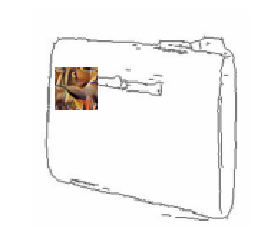

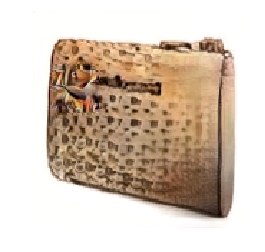

In [42]:
color_space = 'lab'

data = valLoader.__iter__().__next__()

img, skg, seg, eroded_seg, txt = data

img = normalize_lab(img)
skg = normalize_lab(skg)
txt = normalize_lab(txt)
seg = normalize_seg(seg)
eroded_seg = normalize_seg(eroded_seg)
inp,texture_loc = get_input(data,-1,-1,30,1)

seg = seg!=0

model = netG
device = torch.device("cpu")

inpv = get_inputv(inp.to(device))
output = model(inpv.to(device))

out_img = vis_image(denormalize_lab(output.data.double().cpu()),
                                    color_space)
inp_img = vis_patch(denormalize_lab(txt.cpu()),
                           denormalize_lab(skg.cpu()),
                            texture_loc,
                            color_space)
tar_img = vis_image(denormalize_lab(img.cpu()),
                        color_space)

plt.figure()
plt.imshow(np.transpose(inp_img[0],(1, 2, 0)))
plt.axis('off')
#plt.figure()  
plt.figure()
plt.imshow(np.transpose(out_img[0],(1, 2, 0)))
plt.axis('off')